<a href="https://colab.research.google.com/github/mishi93999/2023_news/blob/main/kobert_colab_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 환경 설정

In [2]:
!pip install mxnet
!pip install gluonnlp==0.8.0
!pip install tqdm pandas
!pip install sentencepiece
!pip install transformers
!pip install torch>=1.8.1

!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 17.4 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gluonnlp: filename=gluonnlp-0.8.0-py3-none-any.whl size=292696 sha256=4fe0ba15d0a4850d1f5011cf5c72bab9cfeab450540ccfb253ea15caa5a3c108
  Stored in directory: /root/.cache/pip/wheels/2d/cc/dc/7ec84dced25f738b8be400101abb67e4b50c905090a51017e4
Successfully built gluonnlp
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 84.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

# 데이터 준비

In [3]:
from google.colab import drive
drive.mount('./gdrive')

Mounted at ./gdrive


In [4]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/mxnet/optimizer/optimizer.py:163: UserWarning: WARNING: New optimizer gluonnlp.optimizer.lamb.LAMB is overriding existing optimizer mxnet.optimizer.optimizer.LAMB
  warnings.warn('WARNING: New optimizer %s.%s is overriding '


In [5]:
# Torch GPU 설정
device_type = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_type)

In [6]:
raw_data = pd.read_excel('gdrive/MyDrive/공모전/2023_News/Datasets/Train_data/tokenized_train_data.xlsx', index_col = 0)

In [7]:
raw_data.head()

,User,Summary,Label,Type,Topic,clean_text
Date,,,,,,
2020-03-24 00:00:00,tkadnjs4770,"#장병완 의원, ‘#청년에게_용기를’ #청년정책 공약 발표\n\n“주거와 취업은 청...",1,트위터,청년정책,장병완 의원 청년 용기 청년 정책 공약 발표 주거 취업 청년 미래 설계 기본 토대 ...
2019-09-15 00:00:00,FairSociety88,"이재명이 있잖아! \n\n최초의 청년배당 청년정책들, 이 모든 정책을 봐! \n\...",0,트위터,청년정책,이재명 최초 청년 배당 청년 정책 정책 이 재명 청년 지원 정치 인 재명 포함 청년...
2019-12-19 00:00:00,TheKoreanOfWill,* #2019년12월19일 의 #오늘의이야기1\n\n: #국무조정실 #청년정책추진단...,1,트위터,청년정책,오늘 이야기 국무 조정 실 청년 정책 주관 청년 기본법 토론회 참석 청년 기본법 기...
2021-05-08 00:00:00,OhmyNews_Korea,'청년'으로 도마 위 오른 이재명과 오세훈 #이재명 #청년정책 #서울시 #오세훈 #...,1,트위터,청년정책,청년 도마 위 이재명 오세훈 이재명 청년 정책 서울시 오세훈 경기도 박정훈 기자
2019-05-02 00:00:00,DikesEye,국무총리실을 청년정책 콘트롤타워로…청년정책조정위 설치 http://yna.kr/AK...,1,트위터,청년정책,국무총리실 청년 정책 콘트롤 타워 청년 정책 조정 위 설치


In [8]:
#스팸열 제거
spam_str = ['자동트윗','특강','캣맘','애견','하반기 뉴스','간추린뉴스','특수형광물질','호수마을 아파트','미사일','헤드라인','힙합엘이','조성진','김석진','마인드컨트롤전파무기','파리','그린가드','흥신소',
            '초음파검사','돌고래','부린이','오픈채팅방','문의전화','주식', '돈쭐','상담문의','광고문의','속도위반','역사교과서','일러스트레이터','데이트미팅','노사갈등',
            '동성결혼','마인드컨트롤','고속도로','음주운전']
# Filter the DataFrame to remove rows containing the specified string
spam_condition =raw_data['Summary'].apply(lambda x: not any(spam in x for spam in spam_str))
print(spam_condition)
data = raw_data[spam_condition]
data.head()

Date
2020-03-24 00:00:00     True
2019-09-15 00:00:00    False
2019-12-19 00:00:00     True
2021-05-08 00:00:00     True
2019-05-02 00:00:00     True
                       ...  
2023/05/16              True
2023/05/16              True
2023/05/17              True
2023/05/17              True
2023/05/17              True
Name: Summary, Length: 4010, dtype: bool


,User,Summary,Label,Type,Topic,clean_text
Date,,,,,,
2020-03-24 00:00:00,tkadnjs4770,"#장병완 의원, ‘#청년에게_용기를’ #청년정책 공약 발표\n\n“주거와 취업은 청...",1,트위터,청년정책,장병완 의원 청년 용기 청년 정책 공약 발표 주거 취업 청년 미래 설계 기본 토대 ...
2019-12-19 00:00:00,TheKoreanOfWill,* #2019년12월19일 의 #오늘의이야기1\n\n: #국무조정실 #청년정책추진단...,1,트위터,청년정책,오늘 이야기 국무 조정 실 청년 정책 주관 청년 기본법 토론회 참석 청년 기본법 기...
2021-05-08 00:00:00,OhmyNews_Korea,'청년'으로 도마 위 오른 이재명과 오세훈 #이재명 #청년정책 #서울시 #오세훈 #...,1,트위터,청년정책,청년 도마 위 이재명 오세훈 이재명 청년 정책 서울시 오세훈 경기도 박정훈 기자
2019-05-02 00:00:00,DikesEye,국무총리실을 청년정책 콘트롤타워로…청년정책조정위 설치 http://yna.kr/AK...,1,트위터,청년정책,국무총리실 청년 정책 콘트롤 타워 청년 정책 조정 위 설치
2021-12-01 00:00:00,yoomyongsook,"결국, 윤석열도 부자본색?? 2030세대 난리났다! 윤석열, 주 52시간 최저임금 ...",0,트위터,청년정책,윤석열 부자 본색 세대 난리 윤석열 주 최저임금 폐지 언급 재명 감동 청년 정책 강...


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3795 entries, 2020-03-24 00:00:00 to 2023/05/17
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   User        3795 non-null   object
 1   Summary     3795 non-null   object
 2   Label       3795 non-null   int64 
 3   Type        3795 non-null   object
 4   Topic       3795 non-null   object
 5   clean_text  3795 non-null   object
dtypes: int64(1), object(5)
memory usage: 207.5+ KB


<Axes: >

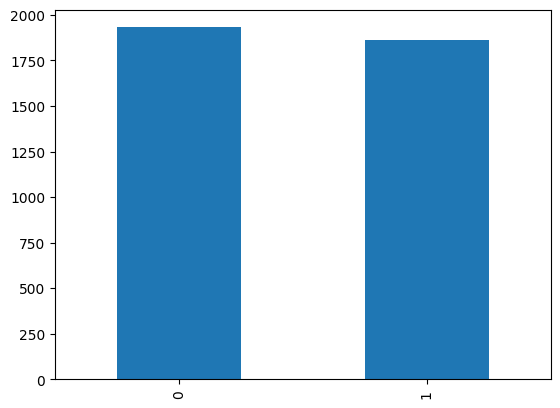

In [10]:
# data.at[1516, 'Label'] = 0

data['Label'].value_counts().plot(kind='bar')

In [11]:
data_list = []
for q, label in zip(data['clean_text'], data['Label']):
    data = []
    data.append(q)
    data.append(str(label))

    data_list.append(data)

In [12]:
from sklearn.model_selection import train_test_split
dataset_train, dataset_test = train_test_split(data_list, test_size = 0.3, shuffle = True, random_state = 23)

In [13]:
print(len(dataset_train), len(dataset_test))

2656 1139


# 모델 불러오기

In [14]:
# BERTSentenceTransform 수정
class BERTSentenceTransform:
    r"""BERT style data transformation.

    Parameters
    ----------
    tokenizer : BERTTokenizer.
        Tokenizer for the sentences.
    max_seq_length : int.
        Maximum sequence length of the sentences.
    pad : bool, default True
        Whether to pad the sentences to maximum length.
    pair : bool, default True
        Whether to transform sentences or sentence pairs.
    """

    def __init__(self, tokenizer, max_seq_length,vocab, pad=True, pair=True):
        self._tokenizer = tokenizer
        self._max_seq_length = max_seq_length
        self._pad = pad
        self._pair = pair
        self._vocab = vocab

    def __call__(self, line):
        """Perform transformation for sequence pairs or single sequences.

        The transformation is processed in the following steps:
        - tokenize the input sequences
        - insert [CLS], [SEP] as necessary
        - generate type ids to indicate whether a token belongs to the first
        sequence or the second sequence.
        - generate valid length

        For sequence pairs, the input is a tuple of 2 strings:
        text_a, text_b.

        Inputs:
            text_a: 'is this jacksonville ?'
            text_b: 'no it is not'
        Tokenization:
            text_a: 'is this jack ##son ##ville ?'
            text_b: 'no it is not .'
        Processed:
            tokens: '[CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]'
            type_ids: 0     0  0    0    0     0       0 0     1  1  1  1   1 1
            valid_length: 14

        For single sequences, the input is a tuple of single string:
        text_a.

        Inputs:
            text_a: 'the dog is hairy .'
        Tokenization:
            text_a: 'the dog is hairy .'
        Processed:
            text_a: '[CLS] the dog is hairy . [SEP]'
            type_ids: 0     0   0   0  0     0 0
            valid_length: 7

        Parameters
        ----------
        line: tuple of str
            Input strings. For sequence pairs, the input is a tuple of 2 strings:
            (text_a, text_b). For single sequences, the input is a tuple of single
            string: (text_a,).

        Returns
        -------
        np.array: input token ids in 'int32', shape (batch_size, seq_length)
        np.array: valid length in 'int32', shape (batch_size,)
        np.array: input token type ids in 'int32', shape (batch_size, seq_length)

        """

        # convert to unicode
        text_a = line[0]
        if self._pair:
            assert len(line) == 2
            text_b = line[1]

        tokens_a = self._tokenizer.tokenize(text_a)
        tokens_b = None

        if self._pair:
            tokens_b = self._tokenizer(text_b)

        if tokens_b:
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            self._truncate_seq_pair(tokens_a, tokens_b,
                                    self._max_seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > self._max_seq_length - 2:
                tokens_a = tokens_a[0:(self._max_seq_length - 2)]

        # The embedding vectors for `type=0` and `type=1` were learned during
        # pre-training and are added to the wordpiece embedding vector
        # (and position vector). This is not *strictly* necessary since
        # the [SEP] token unambiguously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.

        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        #vocab = self._tokenizer.vocab
        vocab = self._vocab
        tokens = []
        tokens.append(vocab.cls_token)
        tokens.extend(tokens_a)
        tokens.append(vocab.sep_token)
        segment_ids = [0] * len(tokens)

        if tokens_b:
            tokens.extend(tokens_b)
            tokens.append(vocab.sep_token)
            segment_ids.extend([1] * (len(tokens) - len(segment_ids)))

        input_ids = self._tokenizer.convert_tokens_to_ids(tokens)

        # The valid length of sentences. Only real  tokens are attended to.
        valid_length = len(input_ids)

        if self._pad:
            # Zero-pad up to the sequence length.
            padding_length = self._max_seq_length - valid_length
            # use padding tokens for the rest
            input_ids.extend([vocab[vocab.padding_token]] * padding_length)
            segment_ids.extend([0] * padding_length)

        return np.array(input_ids, dtype='int32'), np.array(valid_length, dtype='int32'),\
            np.array(segment_ids, dtype='int32')

In [15]:
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertModel
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, vocab, max_len,
                 pad, pair):
        transform = BERTSentenceTransform(bert_tokenizer, max_seq_length=max_len,vocab=vocab, pad=pad, pair=pair)
        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [16]:
from kobert_tokenizer import KoBERTTokenizer
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


In [17]:
# kobert 공식 git에 있는 get_kobert_model 선언
def get_kobert_model(model_path, vocab_file, ctx="cpu"):
    bertmodel = BertModel.from_pretrained(model_path)
    device = torch.device(ctx)
    bertmodel.to(device)
    bertmodel.eval()
    vocab_b_obj = nlp.vocab.BERTVocab.from_sentencepiece(vocab_file,
                                                         padding_token='[PAD]')
    return bertmodel, vocab_b_obj

In [18]:
import gluonnlp as nlp
from transformers import BertModel
bertmodel, vocab = get_kobert_model('skt/kobert-base-v1',tokenizer.vocab_file)
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower = False)

In [19]:
# # 하이퍼 파라미터 설정
max_len = 100
batch_size = 64
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [20]:
data_train = BERTDataset(dataset_train, 0, 1, tokenizer, vocab, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tokenizer, vocab, max_len, True, False)

In [21]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size = batch_size, num_workers = 5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size = batch_size, num_workers = 5)

In [ ]:
# option 2

import torch
import torch.nn as nn
import torch.nn.functional as F  # Import for GELU

class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size=768,
                 num_classes=2,
                 dr_rate=0.2,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size, num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)

        _, pooler = self.bert(input_ids=token_ids, token_type_ids=segment_ids.long(), attention_mask=attention_mask.float().to(token_ids.device), return_dict=False)
        if self.dr_rate:
            out = self.dropout(pooler)

        # Apply GELU activation
        out = F.gelu(out)

        return self.classifier(out)


In [31]:
# option 1
# import torch
# import torch.nn as nn

# # Define the GELU activation function
# class GeluLayer(nn.Module):
#     def forward(self, x):
#         return 0.5 * x * (1 + torch.tanh(0.79788 * (x + 0.044715 * torch.pow(x, 3))))

# class BERTClassifier(nn.Module):
#     def __init__(self,
#                  bert,
#                  hidden_size=768,
#                  num_classes=2,
#                  dr_rate=0.2,
#                  params=None):
#         super(BERTClassifier, self).__init__()
#         self.bert = bert
#         self.dr_rate = dr_rate

#         self.classifier = nn.Linear(hidden_size, num_classes)
#         if dr_rate:
#             self.dropout = nn.Dropout(p=dr_rate)

#         self.gelu = GeluLayer()  # Add GELU activation layer

#     def gen_attention_mask(self, token_ids, valid_length):
#         attention_mask = torch.zeros_like(token_ids)
#         for i, v in enumerate(valid_length):
#             attention_mask[i][:v] = 1
#         return attention_mask.float()

#     def forward(self, token_ids, valid_length, segment_ids):
#         attention_mask = self.gen_attention_mask(token_ids, valid_length)

#         _, pooler = self.bert(input_ids=token_ids, token_type_ids=segment_ids.long(), attention_mask=attention_mask.float().to(token_ids.device), return_dict=False)
#         if self.dr_rate:
#             out = self.dropout(pooler)
#         out = self.gelu(out)  # Apply GELU activation
#         return self.classifier(out)


In [29]:
# original

# class BERTClassifier(nn.Module):
#     def __init__(self,
#                  bert,
#                  hidden_size = 768,
#                  num_classes = 2,   # 감정 클래스 수로 조정 긍정/부정 클래스2개
#                  dr_rate = 0.2,
#                  params = None):
#         super(BERTClassifier, self).__init__()
#         self.bert = bert
#         self.dr_rate = dr_rate

#         self.classifier = nn.Linear(hidden_size , num_classes)
#         if dr_rate:
#             self.dropout = nn.Dropout(p = dr_rate)

#     def gen_attention_mask(self, token_ids, valid_length):
#         attention_mask = torch.zeros_like(token_ids)
#         for i, v in enumerate(valid_length):
#             attention_mask[i][:v] = 1
#         return attention_mask.float()

#     def forward(self, token_ids, valid_length, segment_ids):
#         attention_mask = self.gen_attention_mask(token_ids, valid_length)

#         _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device),return_dict = False)
#         if self.dr_rate:
#             out = self.dropout(pooler)
#         return self.classifier(out)

In [32]:
model = BERTClassifier(bertmodel,  dr_rate = 0.5).to(device)

In [33]:
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr = learning_rate)
loss_fn = nn.CrossEntropyLoss() # 다중분류를 위한 loss function

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps = warmup_step, num_training_steps = t_total)


In [34]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

train_dataloader

# 모델 학습

In [35]:
from sklearn.metrics import f1_score, precision_score, recall_score
import torch, gc

train_history = []
test_history = []
loss_history = []
f1_history = []
precision_history = []
recall_history = []

for e in range(num_epochs):
    train_acc = 0.0                   #accuracy initialized
    test_acc = 0.0
    test_f1 = 0.0
    test_precision = 0.0
    test_recall = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad()        #gradient zeroed
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)

        # print(label.shape, out.shape)
        loss = loss_fn(out, label)    #calculate loss
        loss.backward()               #backpropagation
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)

        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
            train_history.append(train_acc / (batch_id+1))
            loss_history.append(loss.data.cpu().numpy())

    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))

    # .eval() : nn.Module에서 train time과 eval time에서 수행하는 다른 작업을 수행할 수 있도록 switching 하는 함수
    # 즉, model이 Dropout이나 BatNorm2d를 사용하는 경우, train 시에는 사용하지만 evaluation을 할 때에는 사용하지 않도록 설정해주는 함수

    model.eval()      #evaluation mode
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
        test_f1 = f1_score(label.cpu().numpy(), out.argmax(dim=1).cpu().numpy(), average='weighted')
        test_precision = precision_score(label.cpu().numpy(), out.argmax(dim=1).cpu().numpy(), average='weighted')
        test_recall = recall_score(label.cpu().numpy(), out.argmax(dim=1).cpu().numpy(), average='weighted')

    print("epoch {} test acc {} test_F1 {} test_Precision {} test_Recall {}".format(
    e+1,test_acc / (batch_id+1), test_f1, test_precision, test_recall))
    test_history.append(test_acc / (batch_id+1))
    f1_history.append(test_f1)
    precision_history.append(test_precision)
    recall_history.append(test_recall)
    gc.collect()
    torch.cuda.empty_cache()

  0%|          | 0/42 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 0.6689189672470093 train acc 0.578125
epoch 1 train acc 0.6019345238095238


  0%|          | 0/18 [00:00<?, ?it/s]

epoch 1 test acc 0.720009531590414 test_F1 0.7915428797781738 test_Precision 0.8555211558307534 test_Recall 0.803921568627451


  0%|          | 0/42 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.5568689703941345 train acc 0.734375
epoch 2 train acc 0.7645089285714286


  0%|          | 0/18 [00:00<?, ?it/s]

epoch 2 test acc 0.7740502450980392 test_F1 0.8174962292609351 test_Precision 0.8463235294117647 test_Recall 0.8235294117647058


  0%|          | 0/42 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.46039876341819763 train acc 0.765625
epoch 3 train acc 0.8288690476190477


  0%|          | 0/18 [00:00<?, ?it/s]

epoch 3 test acc 0.7970452069716776 test_F1 0.7838091961930972 test_Precision 0.7839141926363021 test_Recall 0.7843137254901961


  0%|          | 0/42 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.3491681218147278 train acc 0.828125
epoch 4 train acc 0.8623511904761905


  0%|          | 0/18 [00:00<?, ?it/s]

epoch 4 test acc 0.7950878267973857 test_F1 0.7650678733031674 test_Precision 0.7748729121278141 test_Recall 0.7647058823529411


  0%|          | 0/42 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.23210567235946655 train acc 0.953125
epoch 5 train acc 0.9025297619047619


  0%|          | 0/18 [00:00<?, ?it/s]

epoch 5 test acc 0.7950878267973857 test_F1 0.7650678733031674 test_Precision 0.7748729121278141 test_Recall 0.7647058823529411


시각화

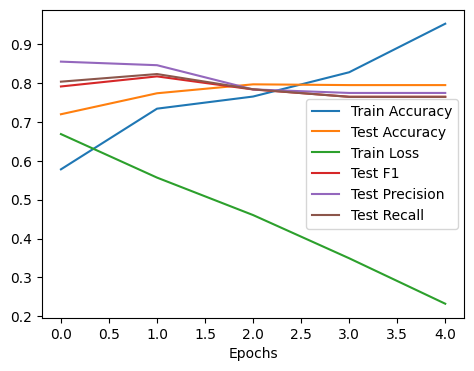

In [36]:
import matplotlib.pyplot as plt

# 학습 과정 시각화
    # 정확도 그래프
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_history, label='Train Accuracy')
plt.plot(test_history, label='Test Accuracy')
plt.plot(loss_history, label='Train Loss')
plt.plot(f1_history, label='Test F1')
plt.plot(precision_history, label='Test Precision')
plt.plot(recall_history, label='Test Recall')

plt.xlabel('Epochs')
plt.legend()

plt.show()



In [37]:
print(f1_history)

[0.7915428797781738, 0.8174962292609351, 0.7838091961930972, 0.7650678733031674, 0.7650678733031674]


Extract mislabeled data

In [38]:
#Create a function to evaluate the model on the test dataset and collect predictions:

def evaluate_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    all_predictions = []
    true_labels = []

    with torch.no_grad():  # Disable gradient computation for inference
        for batch in dataloader:
            token_ids, valid_length, segment_ids, labels = batch
            token_ids = token_ids.to(device)
            segment_ids = segment_ids.to(device)
            valid_length = valid_length
            labels = labels.to(device)

            # Forward pass to get model predictions
            predictions = model(token_ids, valid_length, segment_ids)
            all_predictions.extend(predictions.argmax(dim=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return all_predictions, true_labels

In [39]:
#Use the evaluate_model function to obtain predictions and true labels:
predicted_labels, true_labels = evaluate_model(model, test_dataloader)

In [40]:
#Compare predictions with true labels to identify mislabeled data:
mislabeled_indices = [i for i, (pred, true) in enumerate(zip(predicted_labels, true_labels)) if pred != true]


In [41]:
#Extract the mislabeled data:
mislabeled_data = [dataset_test[i] for i in mislabeled_indices]
mislabeled_data

[['의사 간호법 반대 글 영상 의사 간호사 영역 침범 간호조무사 의료 인 간호사 영역', '1'],
 ['소녀 팬 기자 제목 가요 문제 남녀 사생팬 스토킹 처벌 법 개월 뒤 말 시행 법 취지 건 집 앞 소녀 팬 짝사랑 순정파 스토커 처벌',
  '1'],
 ['오늘 뉴스 대통령 전 무릎 수 귀국 송영길 사안 상황 파악 해결 앞장 대통령실 정부 수단 교민 안전 철수 최선 중 쌍 특검 추진 가속 페달 오수 소환 산 압수수색 건축 왕 천억 원 자산 구속 직전 피해자 회유 만 위반 우회전 범칙금 사흘 혼란 대중 압박 기업 동참 요구 설상가상 반도체 주한 대사관 수교 중국 존중 내정 간섭 반대 초 중 고교 신규 교사 선발 최대 국방부 포병 탄약 보유 대비 태세 유지 지장 대통령실 강행 예고 간호법 방송법 거부 기류 감지 은 총 한 미 정상 회담 통화 스와프 얘기 듯 원 달러 환율 원 원 마감 연고 점 경신 전국 비 오후 버스 추가 투입 첫날 오늘 김포 철도 지옥 철 국내 감염 추정 엠 폭스 환자 추가 누적 명 윤리 위 구성 김재원 직권 회부 전 징계 주목 최강욱 고발 사주 배후 대통령 증언 정부 북 개성 공단 무단 가동 법 대응 다각 방안 검토 기재 차관 마약 수사 인프라 조성 내년 예산 반영 공직자 비리 특별 단속 검거 구속 패스트푸드 버거 세트 만 원 근접 버거킹 제품 출시 우크라 군 프로 강 동쪽 거점 봄철 반격 가능 김만배 돈거래 언론인 해고 유지 법원 결정 항고 초 당 정치 개혁 모임 전원 위 소위 구성 요청 힘 공 수처 검사 명 기 절반 퇴직 분기 건설 사고 사망 건설사 현장 월급 이 자 부수입 천 만 원 직장 내달 전국 아파트 천 가구 입주 서울 만 물량 김포 열풍기 제조 공장 화재 만 불길 권영세 북한 인권 개선 실질 통일 준비 적극 지원 일본 후쿠시마 원전 호기 원자 바닥 구멍 가능 창원 간첩 피고인 국민 참여 재판 신청 상식 필요 멕시코 우족 성장 보조제 초과 검출 판매 중단 회수 코로나 이후 휴가 키워드 해외 중 단거리 비수기 인력난 조선업 전용 

In [42]:
PATH = 'gdrive/MyDrive/공모전/2023_News/Yen'
torch.save(model.state_dict(), PATH + 'koBert.pt')  # 모델 객체의 state_dict 저장

Input Test

In [43]:
def predict(predict_sentence):

    data = [predict_sentence, 0]
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, max_len, True, False)
    test_loader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)

    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_loader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)

        test_eval=[]
        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()

            if np.argmax(logits) == 0:
                test_eval.append("0")
            else:
                test_eval.append("1")

        print(test_eval[0])

Research:

https://github.com/ChangZero/koBERT-finetuning-demo/blob/main/kobert_colab.ipynb